# Topic modeling using EHR
- Apply a Topic Modeling analysis to uncover the underlying factors for a given medical condition. 
- Each txt file contains pertinent sections such as the Chief Complaint and History of Present Illnesses which are the focal point of this exercise. 
- Accompanying each file are annotations representing the output of a named entity recognition process. This should help compliment the factors found during the topic modeling analysis. 


In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim, string

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

from os import listdir
from wordcloud import WordCloud
import pickle

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

In [115]:
# load one file
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load all the files in a directory
def process_docs(directory):
    filenames = list()
    docs = list()
    for filename in listdir(directory):
        path = directory + '/' + filename
        # load document
        filenames.append(filename)
        docs.append(load_doc(path))
    print('Loaded %d files' % len(filenames))
    return filenames, docs

# load both txt and ann files and put them in a dataframe sorted by id
def build_df(directory):
    filenames,docs = process_docs(directory)
    df = pd.DataFrame(list(zip(filenames, docs)), columns=['filename','content'])
    df['id'] = df.filename.apply(lambda x: x.split('.')[0])
    df['ext'] = df.filename.apply(lambda x: x.split('.')[1])
    df = df.pivot(index='id',columns='ext')
    df.columns = ['filename_ann','filename_txt','content_ann','content_txt']
    df = df.reset_index()
    df = df.sort_values(by=['id'],ignore_index=True)
    return df

#Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers, replace line break with space.
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\n', ' ', text)
    return text

#lemmatization
nlp = spacy.load('en')
def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    output = " ".join(sent)
    output = re.sub('-PRON-', '', output)
    return output

# preprocess text, remove punctuation and lemmatize
def text_preprocess(text):
    text_clean = clean_text(text)
    text_lemmatized = lemmatizer(text_clean)
    return text_lemmatized

# create a new column with preprocessed text
def column_preprocess(df, col):
    data_list = df[col].values.tolist()
    data_lemmatized = [text_preprocess(data) for data in data_list]

    #add the processed content as a new column to the dataframe
    df[col + '_preprocessed'] = data_lemmatized
    return df

# After comparing the stop_words list from nltk, word cloud and sklearn, 
# slkean has the most extensive list, thus was chosen as the default stop_words list
def default_stop_words():
    return text.ENGLISH_STOP_WORDS

# find the potential field names from the original uncleaned text, 
# which were marked with a : at the end of the line
def find_field_names(df, col):
    field_names = set()
    for row in df[col]:
        row_sentences = list(row.split('\n'))
        row_sentences = [sentence for sentence in row_sentences if sentence!='']
        new_field_names = [sentence[:-1] for sentence in row_sentences if sentence[-1]==':']
        field_names = field_names.union(new_field_names)
    field_names = list(field_names)
    
    percent = []
    for field_name in field_names:
        count = 0
        for row in df[col]:
            if field_name in row:
                 count = count+1 
        current_percent = count/df.shape[0]*100
        percent.append(current_percent)
    df = pd.DataFrame(list(zip(field_names, percent)), columns = ['field_name', 'percent'])
    df = df.sort_values('percent',ascending = False,ignore_index=True)
    
    plt.figure(figsize=(20, 4))
    plt.plot(df.percent)
    plt.xlabel('index of stop words')
    plt.ylabel('percentage of  occurance in all the files')
    plt.show()
    return df

# extract major fields from the original uncleaned text files
# starting from the field name, and end at the first empty line following the section name
def extract_content_of_interest(original_text, content_of_interest):
    content = ''
    t = pd.DataFrame(original_text.split('\n'))
    t.columns = ['content']
    # some major fields we are interested in are separated by empty lines
    empty_line_indices = t.index[t['content']==''].to_list()
    # find the index of the line that has the title of the content of interest
    content_start_index = t.index[t['content']==content_of_interest].to_list()
    if content_start_index ==[]:
       output = '' 
    else:
        content_start_index = content_start_index[0]

        for empty_line_index in empty_line_indices:
            if empty_line_index > content_start_index:
                content_end_index = empty_line_index
                break
        output = ','.join(t.content[content_start_index+1:content_end_index])   
    return output

#extract a field content from the whole dataframe, and do text cleaning
def extract_content_of_interest_df_clean(df, content_of_interest):
    new_colname = content_of_interest[:-1].lower()
    new_colname = re.sub(' ', '_', new_colname)
    df[new_colname] = df['content_txt'].apply(lambda x: extract_content_of_interest(x, content_of_interest))    
    df[new_colname + '_preprocessed'] = df[new_colname].apply(lambda x: text_preprocess(x))
    n_empty_rows = df[df[new_colname]==''].shape[0]
    total_rows = df.shape[0]
    print(content_of_interest, 'total rows', total_rows, '\nempty_rows', n_empty_rows)
    return df

#make a word cloud giving the text in a list, and stop words
def make_word_cloud(data_list, stop_words=default_stop_words()):

    wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(' '.join(data_list))
    print(wordcloud)
    fig = plt.figure(1)
    rcParams['figure.figsize']=(12.0,12.0)  
    rcParams['font.size']=12            
    rcParams['savefig.dpi']=100             
    rcParams['figure.subplot.bottom']=.1 
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show();
    
#calculate unigram/bigram/trigram with stop_words
def get_top_ngram(data, ngram=1, top_n=None, stop_words=default_stop_words()):
    ngram_names = ['unigram','bigram','trigram']
    ngram_name = ngram_names[ngram-1]
    #calculate unigram
    vec = CountVectorizer(ngram_range = (ngram, ngram), stop_words=stop_words).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    common_words = words_freq[:top_n]
    #visulization
    df = pd.DataFrame(common_words, columns = [ngram_name , 'count'])
    fig = go.Figure([go.Bar(x=df[ngram_name], y=df['count'])])
    fig.update_layout(title=go.layout.Title(text="Top " + str(top_n) + ' '+ ngram_name))
    fig.show()

# vectorize the content
def get_data_vectorized(data, stop_words=default_stop_words()):
    vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                         # minimum requied occurences of a word 
                             stop_words=stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=50000,             # max number of unique words
                            )

    data_vectorized = vectorizer.fit_transform(data)
    # Materialize the sparse data
    data_dense = data_vectorized.todense()

    # Compute Sparsicity = Percentage of Non-Zero cells
    print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")
    return data_vectorized, vectorizer

# grid search on n_components and learning_decay
def lda_grid(data_vectorized):
    # Define Search Param
    search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(data_vectorized)
    return model

# find the best model and plot the performance of all the grid search parameters
def describe_best_model(model,data_vectorized):
    # Best Model
    best_lda_model = model.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score
    print("Best Log Likelihood Score: ", model.best_score_)

    # Perplexity
    print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))
    
    # Get Log Likelyhoods from Grid Search Output
    n_topics = [10, 15, 20, 25, 30]
    log_likelyhoods_5 = model.cv_results_['mean_test_score'][0:5]
    log_likelyhoods_7 = model.cv_results_['mean_test_score'][5:10]
    log_likelyhoods_9 = model.cv_results_['mean_test_score'][10:15]
    # Show graph
    plt.figure(figsize=(12, 8))
    plt.plot(n_topics, log_likelyhoods_5, label='0.5')
    plt.plot(n_topics, log_likelyhoods_7, label='0.7')
    plt.plot(n_topics, log_likelyhoods_9, label='0.9')
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    return best_lda_model

# conduct the whole process of vectorization, grid search, and find the best model
def do_lda(data, stop_words=default_stop_words()):
    data_vectorized, vectorizer = get_data_vectorized(data, stop_words)
    model = lda_grid(data_vectorized);
    best_lda_model = describe_best_model(model,data_vectorized)
    lda_output={}
    lda_output['best_lda_model'] = best_lda_model
    lda_output['model'] = model
    lda_output['data_vectorized'] = data_vectorized
    lda_output['vectorizer'] = vectorizer
    return lda_output

# create document topic matrix
def create_document_topic_matrix(best_lda_model, data_vectorized):
    # Create Document - Topic Matrix
    lda_output = best_lda_model.transform(data_vectorized)

    # column names
    topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

    # index names
    docnames = ["Doc" + str(i) for i in range(data_vectorized.shape[0])]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic
    # Apply Style
    df_document_topic_top = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
    return df_document_topic, df_document_topic_top, topicnames

    # Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# get_topic_distribution
def get_topic_distribution(df_document_topic):
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    return df_topic_distribution

# show topics
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

    return topic_keywords, df_topic_keywords

# get topic-keyword matrix
def get_topic_keyword_matrix(lda_model, vectorizer, topicnames):
    df_topic_keywords_matrix = pd.DataFrame(lda_model.components_)

    df_topic_keywords_matrix.columns = vectorizer.get_feature_names()
    df_topic_keywords_matrix.index = topicnames

    return df_topic_keywords_matrix

# get the lda panel for showing
def get_lda_panel(lda_output):
    panel = pyLDAvis.sklearn.prepare(lda_output['best_lda_model'], 
                                     lda_output['data_vectorized'], 
                                     lda_output['vectorizer'], 
                                     mds='tsne')
    return panel

# get several metrics from the lda model
def evalute_lda(lda_output):
    best_lda_model = lda_output['best_lda_model']
    data_vectorized = lda_output['data_vectorized']
    vectorizer = lda_output['vectorizer']
                                            
    df_document_topic, df_document_topic_top, topicnames = create_document_topic_matrix(best_lda_model, data_vectorized)
    df_topic_distribution = get_topic_distribution(df_document_topic)
    topic_keywords, df_topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20)
    df_topic_keywords_matrix = get_topic_keyword_matrix(best_lda_model, vectorizer, topicnames)
    lda_metrics = {}
    lda_metrics['df_document_topic_top'] = df_document_topic_top
    lda_metrics['df_topic_distribution'] = df_topic_distribution
    lda_metrics['df_topic_keywords'] = df_topic_keywords
    lda_metrics['df_topic_keywords_matrix'] = df_topic_keywords_matrix
    return lda_metrics

# make prediction
def predict_topic(data, lda_output, lda_metrics):
    
    if type(data)==str: #single prediction
    # Step 1: Clean with the text
        data_1 = [text_preprocess(data)]
    else: # a list of content to predict
        data_1 = [text_preprocess(row) for row in data]

    # Step 2: Vectorize transform
    data_2 = lda_output['vectorizer'].transform(data_1)

    # Step 3: LDA Transform
    topic_probability_scores = lda_output['best_lda_model'].transform(data_2)
    topic = lda_metrics['df_topic_keywords'].iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores


# 1. Import all the files and build a data frame

In [96]:
#import all the files and build a data frame
df = build_df('training_20180910')

Loaded 606 files


In [97]:
df.head()

,id,filename_ann,filename_txt,content_ann,content_txt
0,100035,100035.ann,100035.txt,T1\tReason 10179 10197\trecurrent seizures\nR1...,Admission Date: [**2115-2-22**] ...
1,100039,100039.ann,100039.txt,T1\tDrug 13213 13222\tmilrinone\nT2\tDrug 1340...,Admission Date: [**2174-4-18**] ...
2,100187,100187.ann,100187.txt,T1\tDrug 10017 10032\tanticoagulation\nT2\tDru...,Admission Date: [**2107-1-17**] ...
3,100229,100229.ann,100229.txt,T1\tDuration 1003 1011\tfive-day\nR1\tDuration...,Admission Date: [**2114-12-24**] ...
4,100564,100564.ann,100564.txt,T1\tDrug 1340 1343\ttPA\nT2\tRoute 1344 1352\t...,Admission Date: [**2144-1-20**] ...


# 2. Extract components and preprocess text 
* Extracted fields: "Chief Complaint", "History of Present Illness", 'Discharge Diagnosis"
* Preprocess: remove punctuation and lemmatization

In [98]:
# preprocess, takes aboutn 90 seconds
df = column_preprocess(df,'content_txt')

In [99]:
df.head()

,id,filename_ann,filename_txt,content_ann,content_txt,content_txt_preprocessed
0,100035,100035.ann,100035.txt,T1\tReason 10179 10197\trecurrent seizures\nR1...,Admission Date: [**2115-2-22**] ...,admission date discharge date ...
1,100039,100039.ann,100039.txt,T1\tDrug 13213 13222\tmilrinone\nT2\tDrug 1340...,Admission Date: [**2174-4-18**] ...,admission date discharge date ...
2,100187,100187.ann,100187.txt,T1\tDrug 10017 10032\tanticoagulation\nT2\tDru...,Admission Date: [**2107-1-17**] ...,admission date discharge date ...
3,100229,100229.ann,100229.txt,T1\tDuration 1003 1011\tfive-day\nR1\tDuration...,Admission Date: [**2114-12-24**] ...,admission date discharge date ...
4,100564,100564.ann,100564.txt,T1\tDrug 1340 1343\ttPA\nT2\tRoute 1344 1352\t...,Admission Date: [**2144-1-20**] ...,admission date discharge date ...


In [104]:
# Extract and clean several important fields from the original text
df = extract_content_of_interest_df_clean(df, 'Chief Complaint:')
df = extract_content_of_interest_df_clean(df, 'History of Present Illness:')
df = extract_content_of_interest_df_clean(df, 'Discharge Diagnosis:')
df.head()

Chief Complaint: total rows 303 
empty_rows 33
History of Present Illness: total rows 303 
empty_rows 34
Discharge Diagnosis: total rows 303 
empty_rows 32


,id,filename_ann,filename_txt,content_ann,content_txt,content_txt_preprocessed,chief_complaint,chief_complaint_preprocessed,history_of_present_illness,history_of_present_illness_preprocessed,discharge_diagnosis,discharge_diagnosis_preprocessed
0,100035,100035.ann,100035.txt,T1\tReason 10179 10197\trecurrent seizures\nR1...,Admission Date: [**2115-2-22**] ...,admission date discharge date ...,"Post-cardiac arrest, asthma exacerbation",postcardiac arrest asthma exacerbation,Mr. [**Known lastname 3234**] is a 36 year old...,mr be a year old gentleman with a pmh sign...,"Anoxic Brain Injury s/p PEA arrest x2,Status A...",anoxic brain injury sp pea arrest asthmaticu...
1,100039,100039.ann,100039.txt,T1\tDrug 13213 13222\tmilrinone\nT2\tDrug 1340...,Admission Date: [**2174-4-18**] ...,admission date discharge date ...,Abdominal Pain,abdominal pain,38 yo F w/ h/o ALL in remission s/p cord trans...,yo f w ho all in remission sp cord transplan...,"Primary:,-Abdominal Pain,-Acute on chronic ren...",primaryabdominal painacute on chronic renal fa...
2,100187,100187.ann,100187.txt,T1\tDrug 10017 10032\tanticoagulation\nT2\tDru...,Admission Date: [**2107-1-17**] ...,admission date discharge date ...,SOB,sob,64 yo woman w/ h/o recurrent PEs s/[**Initials...,yo woman w ho recurrent pes s filter gibwh...,"Primary:,1) Pulmonary Embolism with history of...",pulmonary embolism with history of dvt and i...
3,100229,100229.ann,100229.txt,T1\tDuration 1003 1011\tfive-day\nR1\tDuration...,Admission Date: [**2114-12-24**] ...,admission date discharge date ...,"Hypotension with elevated lactate, code sepsis.",hypotension with elevated lactate code sepsis,44 yoM PMH ESRD secondary to Brights disease o...,yom pmh esrd secondary to brights disease on...,"Primary:,1. Sepsis,2. Shock liver,3. Heparin-i...",shock heparininduce endstage renal dise...
4,100564,100564.ann,100564.txt,T1\tDrug 1340 1343\ttPA\nT2\tRoute 1344 1352\t...,Admission Date: [**2144-1-20**] ...,admission date discharge date ...,SVC thrombosis,svc thrombosis,"43 yo male with hx of rectal CA, DMII, and his...",yo male with hx of rectal ca dmii and histop...,"1. Deep Vein Thrombosis of subclavian vein,2. ...",deep vein thrombosis of subclavian rectal ...


# 3. Conduct topic modeling using the whole text files
## 3.1 Find extra stop words
* Field names that appear in almost every txt file and list them
* Examed the percentage of occurance in all the files, and the words
* Used the first 30 words from the potential field names as extra stop words

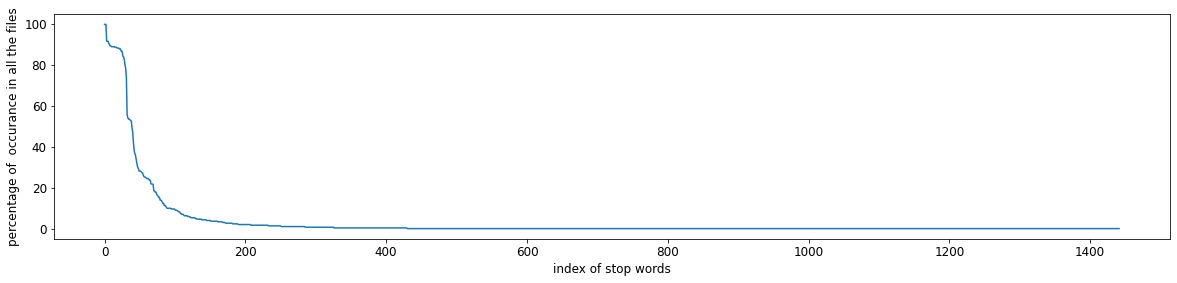

In [57]:
#find the project specific stop words -- words that looked like a field name and also appeared in a certain percentage of the files
df_extra_stopwords = find_field_names(df, 'content_txt')

In [58]:
# Seems like the first 30 words are good stop words for the project, 
# they are mostly the field names
# they don't include any terms that are related to specific procedure
print('first 50 field names')
print(' '.join(df_extra_stopwords.field_name[0:50]))
extra_stop_words = list(df_extra_stopwords.field_name[0:30])
print('\ncut off percentage', df_extra_stopwords.percent[29])
print('\nextra stop words')
print(' '.join(extra_stop_words))
extra_stop_words = text_preprocess(' '.join(extra_stop_words))
print('\nextra stop words after preprocess')
print(extra_stop_words)


first 50 field names
Admission Discharge Service Dispo Allergies Discharge Disposition History of Medications Discharge Condition Discharge Diagnosis Brief Hospital Course History of Present Illness Hospital Course Major Surgical or Invasive Procedure Chief Complaint Social History Social Exam Discharge Instructions Physical Exam Past Medical History Followup Instructions Medications on Admission Family History Discharge Medications Pertinent Results ID CV any discharge HEENT PE Neuro Facility pressure Home GI following CXR secondary IMPRESSION PCP primary General Primary MS cultures NEURO EXT Stable

cut off percentage 80.19801980198021

extra stop words
Admission Discharge Service Dispo Allergies Discharge Disposition History of Medications Discharge Condition Discharge Diagnosis Brief Hospital Course History of Present Illness Hospital Course Major Surgical or Invasive Procedure Chief Complaint Social History Social Exam Discharge Instructions Physical Exam Past Medical History Foll

In [61]:
stop_words = default_stop_words()
print(len(stop_words), 'default stop words:')
print(' '.join(stop_words))

#combine default and extra stop words
stop_words = stop_words.union(list(extra_stop_words))
print('\n', len(stop_words), 'default stop words after adding extra stop words:')
print(' '.join(stop_words))


318 default stop words:
detail whom per it be de during he least forty thru or were not their her both con yourself whoever within thereafter its re no though mine with such ten nowhere whose take my therein found has show therefore on the throughout if ltd always must hereafter yourselves please himself bill seemed i while alone them latter hasnt against side your very they across ours us two get nine nothing fifteen above towards our of whatever ie none she thick you couldnt next why describe thus amoungst cry whole namely nevertheless cant beforehand before behind each else elsewhere something full few him should whenever six upon after much any formerly once whereafter although even where me another whereas that hence without mostly a beside twenty everything bottom yet herself along either thereby interest between am through nor off yours five because myself and eleven who same there most become was done eg someone now top beyond seems un in eight whither inc more had thereupon pe

## 3.2 Make a word cloud and check ngrams
* Observation: There are still a lot of words that are not about the actual symptom or disease. 
* It is to be expected though because text file as a whole has a lot of content.
* Things that are not directly related to symptom or disease may still contribute to prediction power.

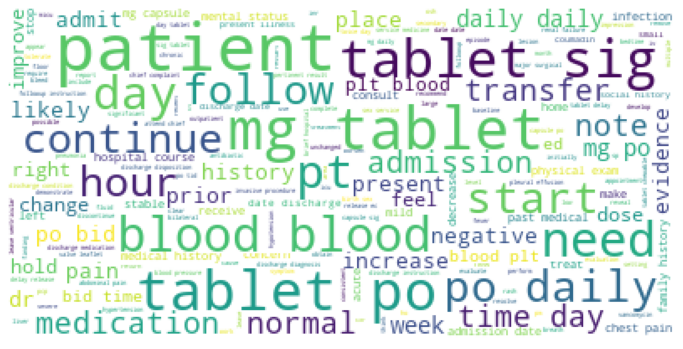

In [62]:
make_word_cloud(df['content_txt_preprocessed'], stop_words)

In [63]:
get_top_ngram(df['content_txt_preprocessed'], ngram=1, top_n=100, stop_words=stop_words)

In [64]:
get_top_ngram(df['content_txt_preprocessed'], ngram=2, top_n=100, stop_words=stop_words)

In [65]:
get_top_ngram(df['content_txt_preprocessed'], ngram=3, top_n=100, stop_words=stop_words)

## 3.3 Build a LDA model and do grid search on learning rate and n_components

* Topics are vague. Need to remove more stop_words
* Probably need more topics too

Topic 0: (medication)	patient	tablet	day	discharge	sig	blood	daily	history	medication	status	admission	time	need	pain	hour	home	date	mental	hospital	continue

Topic 1: (blood related medication)	tablet	sig	daily	day	discharge	blood	time	pain	history	need	patient	release	capsule	coumadin	leave	unit	medication	hour	admission	follow

Topic 2: (liver)	blood	tablet	discharge	patient	daily	liver	day	sig	history	admission	time	date	medication	transplant	place	continue	fluid	cirrhosis	follow	service

Topic 3: (hemorrhage)	tablet	sig	right	discharge	left	day	blood	pain	history	time	medication	head	hemorrhage	need	daily	hour	lesion	increase	patient	mass

Topic 4: (renal)	patient	discharge	status	history	day	admission	failure	right	daily	disease	start	place	blood	left	renal	course	continue	date	tube	note

Topic 5: (lung)	right	tablet	blood	patient	sig	pain	left	normal	effusion	small	low	day	negative	chest	pleural	need	fluid	lobe	pulmonary	discharge

Topic 6: (culture)	blood	discharge	normal	history	patient	admission	day	right	date	culture	pain	urine	valve	medication	daily	left	mitral	present	tablet	aortic
Topic 7: ()	tablet	day	daily	discharge	sig	blood	patient	pain	history	medication	start	admission	time	fever	need	deny	negative	continue	home	acute
Topic 8: (heart disease, ventricular)	blood	daily	patient	right	tablet	cardiac	normal	chest	pain	history	start	ventricular	heart	discharge	artery	disease	leave	present	stenosis	pressure

Topic 9: (hernia)	finding	abnormal	normal	hernia	midline	tpn	hiatal	repair	large	paraesophageal	picc	room	peg	operating	symmetric	incision	cardiovascular	chest	eat	delirium

Sparsicity:  7.928833259239602 %


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -709363.1479353914
Model Perplexity:  1677.103309341974


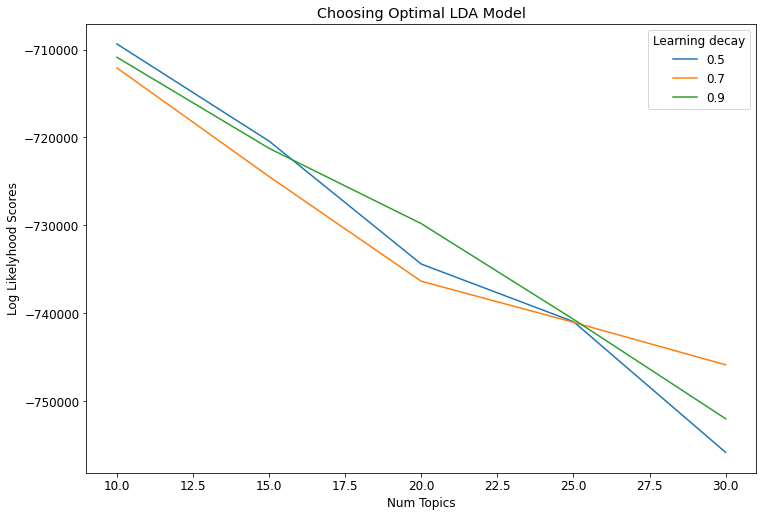

In [66]:
# takes about 5.5 minutes
txt_lda_output = do_lda(df['content_txt_preprocessed'])

In [105]:
pyLDAvis.enable_notebook()
panel = get_lda_panel(txt_lda_output)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      144.011948  320.022949       1        1  17.132429
6     -127.150566  -20.220152       2        1  14.040305
5      -93.678726  255.336868       3        1  13.966574
7     -182.651047 -294.083679       4        1  13.742913
0     -326.734253  175.548584       5        1  13.461542
3      330.301361  120.296677       6        1   8.310222
4     -368.906281  -94.293755       7        1   6.776442
8       55.168037 -229.655746       8        1   6.509381
2      288.185516 -149.581177       9        1   5.942617
9       88.613785   46.000069      10        1   0.117575, topic_info=          Term         Freq        Total Category  logprob  loglift
1967   finding   342.000000   342.000000  Default  30.0000  30.0000
3466    normal  1132.000000  1132.000000  Default  29.0000  29.0000
5090    tablet  4417.000000  4417.000000  Default  28.0000  28.0000
3770   patient  2867.000000  2867.000000  Default  27.0000  27.0000
4720       sig  2627.000000  2627.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2820     large     1.156577   310.103602  Topic10  -5.6079   1.1544
1630       eat     0.910670    73.152118  Topic10  -5.8469   2.3597
2268      heal     0.845174    63.081464  Topic10  -5.9216   2.4332
2544  incision     0.923604   203.372472  Topic10  -5.8328   1.3513
864      chest     0.914021   916.691950  Topic10  -5.8432  -0.1648

[873 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1         5  0.300388          aao
1         9  0.450582          aao
1        10  0.150194          aao
9         8  0.929915   abdominial
13        9  0.839689      abdsoft
...     ...       ...          ...
5706      8  0.031149        wound
5706      9  0.046724        wound
5715      5  0.940096        xanax
5716      8  0.941059  xanthalesma
5717      8  0.941059    xanthomas

[2630 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 6, 8, 1, 4, 5, 9, 3, 10])

In [106]:
txt_lda_metrics = evalute_lda(txt_lda_output)
txt_lda_metrics['df_document_topic_top']

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.620000,0.140000,0.000000,0.010000,0.000000,0.050000,0.170000,0.000000,0.010000,0.000000,0
Doc1,0.000000,0.180000,0.030000,0.000000,0.000000,0.630000,0.030000,0.000000,0.130000,0.000000,5
Doc2,0.000000,0.240000,0.000000,0.000000,0.000000,0.490000,0.000000,0.270000,0.000000,0.000000,5
Doc3,0.020000,0.330000,0.140000,0.000000,0.220000,0.210000,0.080000,0.010000,0.010000,0.000000,1
Doc4,0.300000,0.170000,0.190000,0.190000,0.000000,0.150000,0.000000,0.000000,0.000000,0.000000,0
Doc5,0.000000,0.490000,0.000000,0.000000,0.300000,0.110000,0.110000,0.000000,0.000000,0.000000,1
Doc6,0.450000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.410000,0.080000,0.000000,0
Doc7,0.410000,0.120000,0.000000,0.000000,0.000000,0.470000,0.000000,0.000000,0.000000,0.000000,5
Doc8,0.000000,0.160000,0.000000,0.230000,0.130000,0.000000,0.480000,0.000000,0.000000,0.000000,6
Doc9,0.000000,0.000000,0.000000,0.000000,0.830000,0.000000,0.000000,0.170000,0.000000,0.000000,4


In [107]:
txt_lda_metrics['df_topic_distribution']

,Topic Num,Num Documents
0,0,58
1,1,56
2,7,48
3,6,41
4,3,23
5,2,22
6,5,21
7,4,20
8,8,14


In [109]:
txt_lda_metrics['df_topic_keywords']

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,patient,tablet,day,discharge,sig,blood,daily,history,medication,status,admission,time,need,pain,hour,home,date,mental,hospital,continue
Topic 1,tablet,sig,daily,day,discharge,blood,time,pain,history,need,patient,release,capsule,coumadin,leave,unit,medication,hour,admission,follow
Topic 2,blood,tablet,discharge,patient,daily,liver,day,sig,history,admission,time,date,medication,transplant,place,continue,fluid,cirrhosis,follow,service
Topic 3,tablet,sig,right,discharge,left,day,blood,pain,history,time,medication,head,hemorrhage,need,daily,hour,lesion,increase,patient,mass
Topic 4,patient,discharge,status,history,day,admission,failure,right,daily,disease,start,place,blood,left,renal,course,continue,date,tube,note
Topic 5,right,tablet,blood,patient,sig,pain,left,normal,effusion,small,low,day,negative,chest,pleural,need,fluid,lobe,pulmonary,discharge
Topic 6,blood,discharge,normal,history,patient,admission,day,right,date,culture,pain,urine,valve,medication,daily,left,mitral,present,tablet,aortic
Topic 7,tablet,day,daily,discharge,sig,blood,patient,pain,history,medication,start,admission,time,fever,need,deny,negative,continue,home,acute
Topic 8,blood,daily,patient,right,tablet,cardiac,normal,chest,pain,history,start,ventricular,heart,discharge,artery,disease,leave,present,stenosis,pressure
Topic 9,finding,abnormal,normal,hernia,midline,tpn,hiatal,repair,large,paraesophageal,picc,room,peg,operating,symmetric,incision,cardiovascular,chest,eat,delirium


In [110]:
txt_lda_metrics['df_topic_keywords_matrix']

,aaa,aao,abcess,abcesse,abd,abdoman,abdomen,abdomenpelvis,abdominal,abdominial,...,zinc,zocor,zofran,zoloft,zolpidem,zone,zoster,zosyn,zyprexa,zyrtec
Topic0,2.910635,2.373927,0.100051,0.100011,14.345880,5.345080,32.511474,0.101319,24.206607,0.100000,...,0.100019,0.100006,3.379389,0.100000,1.812297,1.972549,0.100011,6.688695,5.097854,0.100047
Topic1,1.751856,0.100002,4.065245,0.100007,37.939596,2.592997,39.542167,0.100009,53.283920,0.100005,...,2.941498,0.100040,12.995374,1.301636,4.962364,2.485063,1.390220,3.147224,0.100003,0.100008
Topic2,0.100015,3.096243,0.100000,0.100000,45.394263,10.870002,7.045207,0.100010,52.352259,0.100000,...,1.099996,0.100000,0.100079,0.975138,0.100019,0.100005,0.100105,11.625054,0.102127,0.100000
Topic3,0.100033,0.100005,0.100015,0.100004,7.395629,7.605376,5.585047,0.100002,12.000386,0.100000,...,0.100004,0.100123,2.406308,0.100030,0.100004,0.100037,0.976231,5.808817,0.100004,0.100001
Topic4,5.725172,0.100000,0.100014,0.100001,10.486737,9.275081,11.202466,0.100021,17.632388,0.100000,...,0.100013,1.124717,0.100005,3.023174,0.100017,1.143544,0.100013,6.379818,1.095048,2.083891
Topic5,1.294722,0.100004,0.100037,0.100005,26.376045,36.892934,51.824510,9.580995,101.093383,0.100003,...,0.100003,0.100010,0.100073,0.100000,5.808085,6.196778,7.527930,1.492690,1.104951,0.100005
Topic6,12.609940,0.100002,0.100029,0.100006,38.212460,14.910915,36.812907,3.196642,81.435222,0.100006,...,3.258452,8.196840,1.948740,0.100000,7.817169,3.702007,0.100028,10.336940,0.100008,1.116019
Topic7,10.610424,0.100017,1.134454,1.111615,22.134560,2.794437,29.461716,0.100022,92.092494,0.100002,...,0.100014,2.978254,5.937534,0.100022,0.100041,0.100006,4.505461,18.320674,0.100005,0.100025
Topic8,9.797204,0.100000,0.100154,5.088351,8.614829,6.613178,14.914506,1.520979,6.803288,8.099983,...,0.100000,0.100011,1.932498,0.100000,0.100005,0.100010,0.100000,0.100007,0.100000,0.100005
Topic9,0.100000,1.829799,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100053,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100080,0.100000,0.100000


## 3.4 Make prediction

In [119]:
my_data = df.content_txt_preprocessed[2]
topic, prob_scores = predict_topic(my_data, txt_lda_output, txt_lda_metrics)
print(topic)

['right', 'tablet', 'blood', 'patient', 'sig', 'pain', 'left', 'normal', 'effusion', 'small', 'low', 'day', 'negative', 'chest', 'pleural', 'need', 'fluid', 'lobe', 'pulmonary', 'discharge']


In [120]:
prob_scores

array([[6.75411615e-05, 2.43167028e-01, 6.75402911e-05, 6.75394322e-05,
        6.75409118e-05, 4.85025168e-01, 6.75408209e-05, 2.71335038e-01,
        6.75379574e-05, 6.75258776e-05]])

# 4. Conduct topic modeling using History of Present Illness
## 4.1 EDA (word cloud and ngrams)

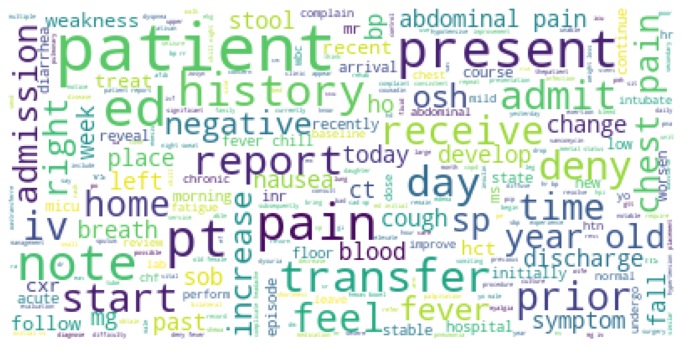

In [123]:
make_word_cloud(df['history_of_present_illness_preprocessed'], stop_words=default_stop_words())

In [124]:
get_top_ngram(df['history_of_present_illness_preprocessed'], ngram=1, top_n=100, stop_words=default_stop_words())

In [125]:
get_top_ngram(df['history_of_present_illness_preprocessed'], ngram=2, top_n=100, stop_words=default_stop_words())

In [126]:
get_top_ngram(df['history_of_present_illness_preprocessed'], ngram=3, top_n=100, stop_words=default_stop_words())

## 4.2 LDA with grid search on history of present illness
* topics are very vague, probably should add more stop words
* seems like to have very little predictibility

Topic 0: ()	pain	present	transfer	blood	start	note	patient	fever	admission	stent	male	history	left	symptom	time	past	chest	feel	stool	report

Topic 1: (abdomial related chest pain)	pain	deny	patient	abdominal	chest	history	fever	day	report	inr	start	nausea	stool	hct	present	chill	initial	ago	prior	time

Topic 2: ()	deny	patient	discharge	history	pain	old	year	tube	rash	repeat	home	bleed	present	negative	refer	seizure	recently	think	cath	chill

Topic 3: ()	patient	pain	note	chest	present	prior	reveal	leave	complain	receive	normal	admission	admit	report	right	cardiac	day	coronary	negative	perform

Topic 4: ()	patient	note	pain	day	history	deny	home	report	time	follow	transfer	year	hct	stool	admit	present	recent	bleed	fall	past

Topic 5: ()	deny	pain	patient	present	report	fever	cough	admit	feel	note	year	transfer	chest	recent	start	abdominal	week	history	breath	diarrhea

Topic 6: ()	patient	transfer	left	report	osh	year	note	pain	chest	right	present	bilateral	old	history	feel	prior	hospital	day	upper	low

Topic 7: ()	patient	day	prior	present	sputum	pain	history	insulin	dose	bring	sob	productive	week	pta	past	infection	symptom	fever	home	husband

Topic 8: ()	patient	pain	osh	note	history	right	lasix	gtt	transfer	place	present	admit	receive	chf	service	renal	cad	inr	left	yearold

Topic 9: ()	pain	deny	patient	present	day	recent	chest	start	transfer	admission	history	prior	cough	note	abdominal	chill	blood	fever	require	improve

Sparsicity:  3.274268005377551 %


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -43219.52345715589
Model Perplexity:  1099.190634988938


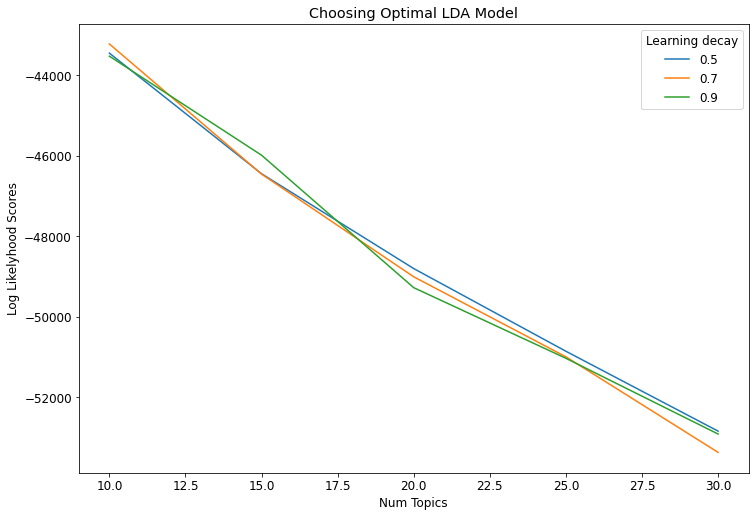

In [121]:
hopi_lda_output = do_lda(df['history_of_present_illness_preprocessed'])

In [122]:
pyLDAvis.enable_notebook()
panel = get_lda_panel(hopi_lda_output)
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      79.658943  64.561066       1        1  24.965352
1      18.452885  94.134216       2        1  13.079876
4      73.399185  -3.130158       3        1  12.712607
3      12.180964  26.436495       4        1  10.393184
9      37.444160  60.505802       5        1   9.167579
0      97.086258  31.210157       6        1   9.087319
6      60.092205  96.698853       7        1   8.613293
7      54.398407  30.493250       8        1   4.434283
8      -5.237254  59.793789       9        1   4.216237
2      31.757786  -5.699854      10        1   3.330269, topic_info=          Term        Freq       Total Category  logprob  loglift
798    patient  284.000000  284.000000  Default  30.0000  30.0000
285       deny  188.000000  188.000000  Default  29.0000  29.0000
274        day  123.000000  123.000000  Default  28.0000  28.0000
769        osh   61.000000   61.000000  Default  27.0000  27.0000
308  discharge   53.000000   53.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
428      fluid    2.545665   25.536388  Topic10  -5.2929   1.0964
861      prior    3.089799   89.003753  Topic10  -5.0992   0.0415
413      fever    3.133959  104.918041  Topic10  -5.0850  -0.1088
193      chest    2.856742  114.039795  Topic10  -5.1776  -0.2847
650       male    2.545688   48.675719  Topic10  -5.2929   0.4513

[707 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2         1  0.798285    abdoman
2         8  0.133048    abdoman
4         1  0.286004  abdominal
4         2  0.321754  abdominal
4         3  0.083418  abdominal
...     ...       ...        ...
1275      2  0.098662    yearold
1275      5  0.049331    yearold
1275      6  0.147992    yearold
1275      8  0.049331    yearold
1275      9  0.197323    yearold

[2036 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 5, 4, 10, 1, 7, 8, 9, 3])

In [127]:
hopi_lda_metrics = evalute_lda(hopi_lda_output)
hopi_lda_metrics['df_document_topic_top']

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.420000,0.000000,0.000000,0.000000,0.000000,0.570000,0.000000,0.000000,0.000000,0.000000,5
Doc1,0.010000,0.910000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,1
Doc2,0.000000,0.000000,0.000000,0.000000,0.000000,0.980000,0.000000,0.000000,0.000000,0.000000,5
Doc3,0.000000,0.530000,0.000000,0.000000,0.000000,0.000000,0.000000,0.470000,0.000000,0.000000,1
Doc4,0.000000,0.000000,0.000000,0.000000,0.000000,0.980000,0.000000,0.000000,0.000000,0.000000,5
Doc5,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Doc6,0.000000,0.000000,0.000000,0.000000,0.670000,0.000000,0.000000,0.310000,0.000000,0.000000,4
Doc7,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
Doc8,0.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.180000,0.200000,0.000000,0.000000,0
Doc9,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0


In [128]:
hopi_lda_metrics['df_topic_distribution']

,Topic Num,Num Documents
0,5,66
1,0,63
2,4,35
3,1,34
4,6,27
5,9,23
6,3,23
7,8,12
8,7,11
9,2,9


In [129]:
hopi_lda_metrics['df_topic_keywords']

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,pain,present,transfer,blood,start,note,patient,fever,admission,stent,male,history,left,symptom,time,past,chest,feel,stool,report
Topic 1,pain,deny,patient,abdominal,chest,history,fever,day,report,inr,start,nausea,stool,hct,present,chill,initial,ago,prior,time
Topic 2,deny,patient,discharge,history,pain,old,year,tube,rash,repeat,home,bleed,present,negative,refer,seizure,recently,think,cath,chill
Topic 3,patient,pain,note,chest,present,prior,reveal,leave,complain,receive,normal,admission,admit,report,right,cardiac,day,coronary,negative,perform
Topic 4,patient,note,pain,day,history,deny,home,report,time,follow,transfer,year,hct,stool,admit,present,recent,bleed,fall,past
Topic 5,deny,pain,patient,present,report,fever,cough,admit,feel,note,year,transfer,chest,recent,start,abdominal,week,history,breath,diarrhea
Topic 6,patient,transfer,left,report,osh,year,note,pain,chest,right,present,bilateral,old,history,feel,prior,hospital,day,upper,low
Topic 7,patient,day,prior,present,sputum,pain,history,insulin,dose,bring,sob,productive,week,pta,past,infection,symptom,fever,home,husband
Topic 8,patient,pain,osh,note,history,right,lasix,gtt,transfer,place,present,admit,receive,chf,service,renal,cad,inr,left,yearold
Topic 9,pain,deny,patient,present,day,recent,chest,start,transfer,admission,history,prior,cough,note,abdominal,chill,blood,fever,require,improve


In [130]:
hopi_lda_metrics['df_topic_keywords_matrix']

,aaa,abd,abdoman,abdomen,abdominal,abdominalpain,abdpain,abg,ablation,able,...,workup,worsen,wound,xray,xrt,year,yearold,yesterday,zofran,zosyn
Topic0,0.100016,1.604212,0.100000,0.100022,7.963084,0.100000,0.100000,0.100000,1.441968,0.100009,...,1.099996,0.100000,0.100103,3.099967,0.100000,7.975471,3.065710,0.100006,0.100000,1.671389
Topic1,2.099996,1.595787,0.100000,1.138796,28.432489,0.100000,0.100000,0.100000,2.100001,0.100000,...,1.099995,6.988431,0.100000,1.099991,0.100000,13.055865,2.303014,5.295944,1.099993,2.259489
Topic2,0.100000,0.100000,0.100012,0.100000,0.100000,0.100000,0.100000,0.100012,0.100000,0.100000,...,0.100000,1.099997,0.100000,1.100008,0.100000,6.040968,0.100000,0.100000,0.100000,2.100010
Topic3,1.742226,2.233646,0.100006,0.100004,5.357787,0.100009,0.100026,0.100061,0.100000,0.100016,...,3.100009,0.100006,0.100000,1.099992,0.100000,3.959647,0.100637,1.099997,4.099990,0.100000
Topic4,1.322316,4.938790,0.100000,1.099996,7.718138,2.099994,2.099976,1.100000,0.758031,6.896891,...,0.100001,9.100017,0.100000,0.100000,1.100001,16.253236,0.100010,1.670197,0.100017,0.100000
Topic5,3.235365,0.100018,6.086571,7.061207,24.726672,1.653131,1.099998,6.074930,0.100000,2.509275,...,2.380090,10.372561,1.319817,0.100042,1.099993,29.665270,9.810672,7.400446,0.100000,4.940461
Topic6,0.100037,3.099956,0.100000,2.099980,0.100009,0.249278,0.100000,0.100000,1.100000,2.873736,...,1.819910,1.314701,2.880060,0.100000,0.100000,14.871862,0.100015,1.099994,0.100000,3.528601
Topic7,1.100015,1.099996,1.099999,0.100000,1.513084,1.397590,0.100000,0.100000,0.100000,1.100002,...,0.100000,1.724300,0.100000,0.100000,1.100009,1.367770,1.107354,2.603623,1.100000,0.100049
Topic8,0.100029,0.100021,0.100000,0.100000,4.100013,0.100000,0.100000,1.124996,0.100000,0.100003,...,1.100000,2.100014,0.100018,0.100000,0.100000,3.182746,4.178323,1.100002,1.099997,0.100000
Topic9,0.100000,1.127572,0.113412,1.099996,9.988724,1.099999,0.100000,1.100000,0.100000,1.120068,...,1.099999,1.099973,1.100002,0.100000,1.099996,2.627165,1.134266,2.529791,3.100003,0.100000


## 4.3 Make predictions

In [131]:
my_data = df['history_of_present_illness'][0]
topic, prob_scores = predict_topic(my_data, hopi_lda_output, hopi_lda_metrics)
print(topic)

['deny', 'pain', 'patient', 'present', 'report', 'fever', 'cough', 'admit', 'feel', 'note', 'year', 'transfer', 'chest', 'recent', 'start', 'abdominal', 'week', 'history', 'breath', 'diarrhea']


In [132]:
prob_scores

array([[0.41774854, 0.00147082, 0.00147092, 0.0014709 , 0.00147098,
        0.57048403, 0.00147106, 0.00147081, 0.00147105, 0.00147089]])

# 5 Topic modeling on discharge diagnosis
# 5.1 EDA (word cloud and ngrams)

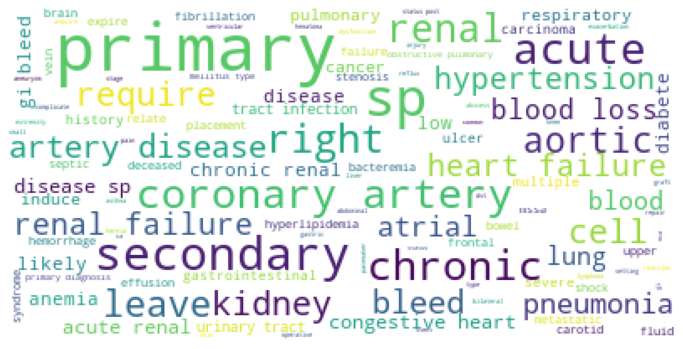

In [135]:
make_word_cloud(df['discharge_diagnosis_preprocessed'], stop_words=default_stop_words())

In [139]:
get_top_ngram(df['discharge_diagnosis_preprocessed'], ngram=1, top_n=20, stop_words=default_stop_words())

In [140]:
get_top_ngram(df['discharge_diagnosis_preprocessed'], ngram=2, top_n=20, stop_words=default_stop_words())

In [141]:
get_top_ngram(df['discharge_diagnosis_preprocessed'], ngram=3, top_n=20, stop_words=default_stop_words())

## 5.2 LDA with grid search with discharge diagnosis 
* the topics are pretty explicit, but there are still many overlaps between topics. 
* need more n_components even though mathematically it would not be ideal, would match the reality better

Topic 0: (gastrointestinal disease,pneumonia, asthma)	primary	associated	bleed	gastrointestinal	pneumonia	pulmonary	hypertension	lung	lymphoma	care	asthma	ventricular	exacerbation	cell	gastric	likely	psychosis	nonsmall	gerd	upper

Topic 1: (brain injury, kidney issues)	right	frontal	bleed	brain	injury	acute	kidney	retroperitoneal	supratherapeutic	anemia	inr	primary	carcinoma	secondary	deficiency	narcotic	fluid	induce	respiratory	failureacute

Topic 2: (renal disease)	renal	acute	failure	require	primary	chronic	syndrome	stent	reflux	cell	pneumonia	mental	status	loss	tract	blood	placement	carcinoma	complicate	htn

Topic 3: (metastatic cancel)	secondary	cell	metastatic	small	primary	cancer	bowel	hyperlipidemia	setting	induce	acute	atrial	reaction	lung	respiratory	bradycardia	post	status	renal	coronary

Topic 4: (anemia, renal)	secondary	blood	acute	low	anemia	renal	bleed	operative	common	right	leave	require	hematoma	ivc	disorder	history	dvt	chronic	likely	kidney

Topic 5: (heart disease, liver)	heart	disease	failure	renal	stage	congestive	liver	artery	secondary	atrial	chronic	end	coronary	transplant	placement	right	relate	pacemaker	post	status

Topic 6: (kidney)	chronic	kidney	bacteremia	fibrillation	bilateral	abscess	type	septic	diabete	diastolic	ulcer	fluid	acquire	leave	drug	mellitus	knee	bleed	pulmonary	acute

Topic 7: (artery issues)	artery	coronary	aortic	graft	disease	bypass	right	cabg	carotid	aneurysm	pain	vein	leave	require	effusion	shock	stenosis	history	prostatic	chest

Topic 8: (chronic disease)	primary	blood	loss	disease	diagnosis	obstructive	chronic	elevation	artery	myocardial	pulmonary	hernia	severe	sepsis	ulcer	mellitus	acute	respiratory	hypertensive	status

Topic 9: (hemorrgage)	primary	tract	hemorrhage	urinary	leave	infection	expire	deceased	multiple	status	atrial	mca	intraparenchymal	artery	mental	cord	renal	fibrillation	cerebral	ventricular

Sparsicity:  2.246353667624827 %


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -2845.714728014107
Model Perplexity:  217.75905220351402


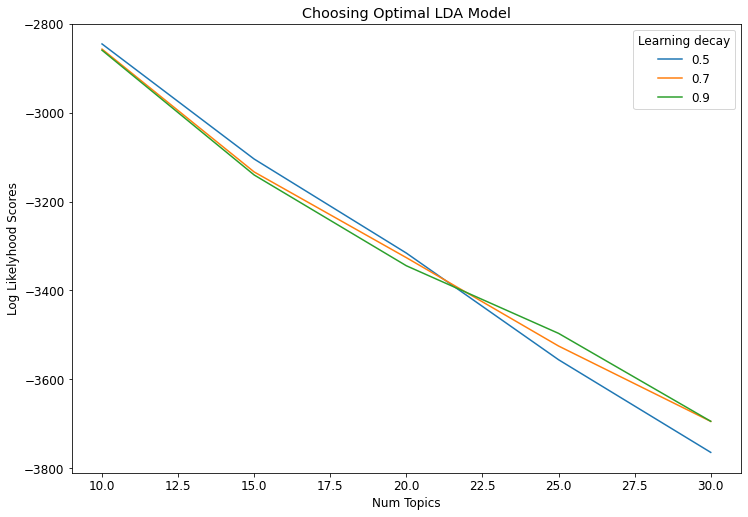

In [142]:
dd_lda_output = do_lda(df['discharge_diagnosis_preprocessed'])

In [143]:
pyLDAvis.enable_notebook()
panel = get_lda_panel(dd_lda_output)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5      102.798820   70.969810       1        1  14.947508
4      276.034729  322.991577       2        1  12.918216
2     -227.399185  132.200958       3        1  12.630600
7      -51.764412 -154.039536       4        1  11.934959
8     -387.926910 -118.864059       5        1   9.838438
9      101.831802 -455.248718       6        1   8.496452
0     -224.846100 -406.168304       7        1   8.238265
6      278.365082 -215.221695       8        1   7.885015
3      -50.653618  372.126068       9        1   6.723616
1      439.064240   35.680794      10        1   6.386931, topic_info=           Term       Freq      Total Category  logprob  loglift
117     primary  49.000000  49.000000  Default  30.0000  30.0000
124       renal  40.000000  40.000000  Default  29.0000  29.0000
40     coronary  20.000000  20.000000  Default  28.0000  28.0000
68        heart  22.000000  22.000000  Default  27.0000  27.0000
10       artery  29.000000  29.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
95          low   0.971073   8.226817  Topic10  -4.3084   0.6142
11   associated   0.971072   8.511691  Topic10  -4.3084   0.5801
13       atrial   0.971109  13.095126  Topic10  -4.3084   0.1494
130   secondary   1.853856  26.307387  Topic10  -3.6618   0.0983
117     primary   1.853878  49.286083  Topic10  -3.6618  -0.5294

[395 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         2  0.448686    abdominal
0         5  0.448686    abdominal
1         8  0.905579      abscess
2         2  0.224281      acquire
2         3  0.224281      acquire
...     ...       ...          ...
153       6  0.239405  ventricular
153       7  0.718215  ventricular
154       3  0.281749       volume
154       4  0.281749       volume
154      10  0.281749       volume

[426 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 3, 8, 9, 10, 1, 7, 4, 2])

In [144]:
dd_lda_metrics = evalute_lda(dd_lda_output)
dd_lda_metrics['df_document_topic_top']

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.010000,0.900000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,1
Doc1,0.020000,0.020000,0.020000,0.020000,0.020000,0.820000,0.020000,0.020000,0.020000,0.020000,5
Doc2,0.000000,0.000000,0.000000,0.000000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,4
Doc3,0.000000,0.000000,0.000000,0.000000,0.000000,0.970000,0.000000,0.000000,0.000000,0.000000,5
Doc4,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.850000,0.020000,0.020000,0.020000,6
Doc5,0.700000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0
Doc6,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.900000,0.010000,8
Doc7,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.700000,9
Doc8,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.770000,0.030000,8
Doc9,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0


In [145]:
dd_lda_metrics['df_topic_distribution']

,Topic Num,Num Documents
0,0,92
1,9,43
2,5,28
3,8,25
4,7,23
5,2,22
6,6,19
7,3,18
8,4,17
9,1,16


In [146]:
dd_lda_metrics['df_topic_keywords']

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,primary,associated,bleed,gastrointestinal,pneumonia,pulmonary,hypertension,lung,lymphoma,care,asthma,ventricular,exacerbation,cell,gastric,likely,psychosis,nonsmall,gerd,upper
Topic 1,right,frontal,bleed,brain,injury,acute,kidney,retroperitoneal,supratherapeutic,anemia,inr,primary,carcinoma,secondary,deficiency,narcotic,fluid,induce,respiratory,failureacute
Topic 2,renal,acute,failure,require,primary,chronic,syndrome,stent,reflux,cell,pneumonia,mental,status,loss,tract,blood,placement,carcinoma,complicate,htn
Topic 3,secondary,cell,metastatic,small,primary,cancer,bowel,hyperlipidemia,setting,induce,acute,atrial,reaction,lung,respiratory,bradycardia,post,status,renal,coronary
Topic 4,secondary,blood,acute,low,anemia,renal,bleed,operative,common,right,leave,require,hematoma,ivc,disorder,history,dvt,chronic,likely,kidney
Topic 5,heart,disease,failure,renal,stage,congestive,liver,artery,secondary,atrial,chronic,end,coronary,transplant,placement,right,relate,pacemaker,post,status
Topic 6,chronic,kidney,bacteremia,fibrillation,bilateral,abscess,type,septic,diabete,diastolic,ulcer,fluid,acquire,leave,drug,mellitus,knee,bleed,pulmonary,acute
Topic 7,artery,coronary,aortic,graft,disease,bypass,right,cabg,carotid,aneurysm,pain,vein,leave,require,effusion,shock,stenosis,history,prostatic,chest
Topic 8,primary,blood,loss,disease,diagnosis,obstructive,chronic,elevation,artery,myocardial,pulmonary,hernia,severe,sepsis,ulcer,mellitus,acute,respiratory,hypertensive,status
Topic 9,primary,tract,hemorrhage,urinary,leave,infection,expire,deceased,multiple,status,atrial,mca,intraparenchymal,artery,mental,cord,renal,fibrillation,cerebral,ventricular


In [147]:
hopi_lda_metrics['df_topic_keywords_matrix']

,aaa,abd,abdoman,abdomen,abdominal,abdominalpain,abdpain,abg,ablation,able,...,workup,worsen,wound,xray,xrt,year,yearold,yesterday,zofran,zosyn
Topic0,0.100016,1.604212,0.100000,0.100022,7.963084,0.100000,0.100000,0.100000,1.441968,0.100009,...,1.099996,0.100000,0.100103,3.099967,0.100000,7.975471,3.065710,0.100006,0.100000,1.671389
Topic1,2.099996,1.595787,0.100000,1.138796,28.432489,0.100000,0.100000,0.100000,2.100001,0.100000,...,1.099995,6.988431,0.100000,1.099991,0.100000,13.055865,2.303014,5.295944,1.099993,2.259489
Topic2,0.100000,0.100000,0.100012,0.100000,0.100000,0.100000,0.100000,0.100012,0.100000,0.100000,...,0.100000,1.099997,0.100000,1.100008,0.100000,6.040968,0.100000,0.100000,0.100000,2.100010
Topic3,1.742226,2.233646,0.100006,0.100004,5.357787,0.100009,0.100026,0.100061,0.100000,0.100016,...,3.100009,0.100006,0.100000,1.099992,0.100000,3.959647,0.100637,1.099997,4.099990,0.100000
Topic4,1.322316,4.938790,0.100000,1.099996,7.718138,2.099994,2.099976,1.100000,0.758031,6.896891,...,0.100001,9.100017,0.100000,0.100000,1.100001,16.253236,0.100010,1.670197,0.100017,0.100000
Topic5,3.235365,0.100018,6.086571,7.061207,24.726672,1.653131,1.099998,6.074930,0.100000,2.509275,...,2.380090,10.372561,1.319817,0.100042,1.099993,29.665270,9.810672,7.400446,0.100000,4.940461
Topic6,0.100037,3.099956,0.100000,2.099980,0.100009,0.249278,0.100000,0.100000,1.100000,2.873736,...,1.819910,1.314701,2.880060,0.100000,0.100000,14.871862,0.100015,1.099994,0.100000,3.528601
Topic7,1.100015,1.099996,1.099999,0.100000,1.513084,1.397590,0.100000,0.100000,0.100000,1.100002,...,0.100000,1.724300,0.100000,0.100000,1.100009,1.367770,1.107354,2.603623,1.100000,0.100049
Topic8,0.100029,0.100021,0.100000,0.100000,4.100013,0.100000,0.100000,1.124996,0.100000,0.100003,...,1.100000,2.100014,0.100018,0.100000,0.100000,3.182746,4.178323,1.100002,1.099997,0.100000
Topic9,0.100000,1.127572,0.113412,1.099996,9.988724,1.099999,0.100000,1.100000,0.100000,1.120068,...,1.099999,1.099973,1.100002,0.100000,1.099996,2.627165,1.134266,2.529791,3.100003,0.100000


## 5.3 Make predictions

In [148]:
my_data = df['discharge_diagnosis'][0]
topic, prob_scores = predict_topic(my_data, dd_lda_output, dd_lda_metrics)
print(topic)

['right', 'frontal', 'bleed', 'brain', 'injury', 'acute', 'kidney', 'retroperitoneal', 'supratherapeutic', 'anemia', 'inr', 'primary', 'carcinoma', 'secondary', 'deficiency', 'narcotic', 'fluid', 'induce', 'respiratory', 'failureacute']


In [149]:
prob_scores

array([[0.01111467, 0.89998696, 0.01111185, 0.01111111, 0.01111142,
        0.01111903, 0.01111133, 0.01111111, 0.01111111, 0.0111114 ]])

# 6 Topic Modeling using chief complaint
## 6.1 EDA (word cloud and ngrams)

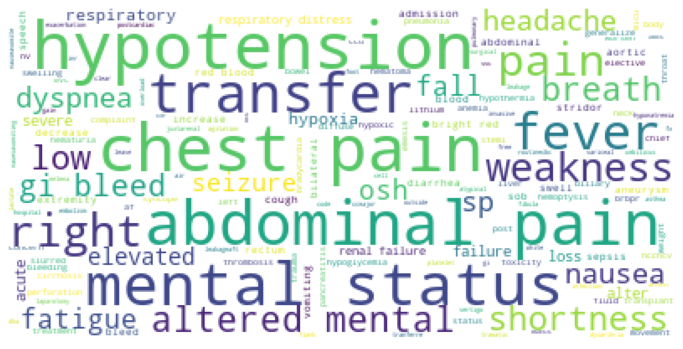

In [150]:
make_word_cloud(df['chief_complaint_preprocessed'], stop_words=default_stop_words())

In [151]:
get_top_ngram(df['chief_complaint_preprocessed'], ngram=1, top_n=20, stop_words=default_stop_words())

In [152]:
get_top_ngram(df['chief_complaint_preprocessed'], ngram=2, top_n=20, stop_words=default_stop_words())

In [153]:
get_top_ngram(df['chief_complaint_preprocessed'], ngram=3, top_n=20, stop_words=default_stop_words())

## 6.2 LDA with grid search by chief complaint
* Observation: the topics are not very well separated, quite a few overlapping topics
* Topics do not provide the underlying conditions either

Topic 0: (infection) fever headache sob cough	transfer	fever	headache	osh	sob	cough	fatigue	failure	sepsis	seizure	status	abdominal	respiratory	mental	pain	bleed	hypotension	altered	hypoxia	increase

Topic 1: (abdominal/renal disease)	failure	loss	renal	acute	aneurysm	blood	admission	abdominal	aortic	sob	nausea	dyspnea	low	alter	mental	status	fever	hypoxia	increase	seizure

Topic 2: (heart disease)	nausea	fatigue	elevated	swell	sepsis	vomiting	severe	aortic	fever	abdominal	hypotension	transfer	admission	loss	pain	hypoxia	sob	increase	seizure	fall

Topic 3: (seizure) chest	pain	seizure	increase	distress	fall	hypotension	headache	speech	right	status	respiratory	abdominal	breath	shortness	weakness	fever	hypoxia	sob	bilateral

Topic 4: ()	dyspnea	stridor	diarrhea	cough	fever	abdominal	renal	pain	failure	breath	shortness	hypoxia	sob	increase	seizure	fall	headache	hypotension	bilateral	swell

Topic 5: (abdominal disease)	pain	abdominal	right	fever	vomiting	weakness	nausea	alter	chest	cough	fall	osh	low	diarrhea	transfer	mental	status	hypoxia	sob	increase

Topic 6: (respiratory disease)	bleed	breath	shortness	increase	cough	osh	low	distress	respiratory	fever	hypoxia	sob	seizure	pain	fall	headache	hypotension	bilateral	swell	failure

Topic 7: (respiratory diease)	respiratory	weakness	distress	speech	bilateral	failure	increase	bleed	osh	extremity	pain	transfer	chest	hypotension	low	abdominal	fever	hypoxia	sob	seizure

Topic 8: (fall incidents)	hypotension	low	fall	extremity	severe	fever	bilateral	increase	blood	right	sepsis	status	weakness	pain	transfer	elevated	bleed	chest	hypoxia	sob

Topic 9: (mental state altered)	status	mental	altered	hypoxia	alter	red	rectum	bright	blood	admission	acute	transfer	seizure	abdominal	pain	hypotension	fever	sob	increase	fall

Sparsicity:  2.376237623762376 %


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -652.9455409126763
Model Perplexity:  57.91451564264936


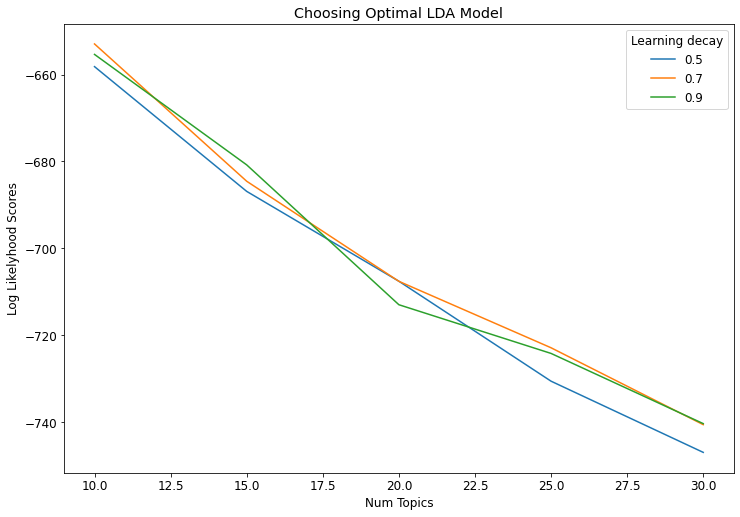

In [154]:
cc_lda_output = do_lda(df['chief_complaint_preprocessed'])

In [155]:
pyLDAvis.enable_notebook()
panel = get_lda_panel(cc_lda_output)
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9       92.793648  270.474884       1        1  15.573006
5      191.818588  -30.617874       2        1  12.605336
3      -99.126328  238.702866       3        1  11.084295
8     -198.951935  -97.539680       4        1   9.884275
1      136.451141 -197.111176       5        1   9.572077
0     -154.549530   72.217201       6        1   9.539980
7      236.270477  139.115219       7        1   8.883374
2      -55.462841 -228.891647       8        1   8.851209
6       -4.229680  -56.252159       9        1   8.001851
4       41.518108   97.846748      10        1   6.004596, topic_info=           Term       Freq      Total Category  logprob  loglift
32         pain  35.000000  35.000000  Default  30.0000  30.0000
24  hypotension  15.000000  15.000000  Default  29.0000  29.0000
12        chest  15.000000  15.000000  Default  28.0000  28.0000
8         bleed  10.000000  10.000000  Default  27.0000  27.0000
47     transfer  11.000000  11.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
49     weakness   0.103794   8.952285  Topic10  -5.3471  -1.6446
9         blood   0.103794   6.316993  Topic10  -5.3471  -1.2960
28          low   0.103794   7.414256  Topic10  -5.3471  -1.4561
8         bleed   0.103794  10.875406  Topic10  -5.3471  -1.8392
47     transfer   0.103794  11.870873  Topic10  -5.3471  -1.9268

[462 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         2  0.791728  abdominal
0         5  0.182706  abdominal
1         5  0.860767      acute
2         5  0.809080  admission
3         1  0.915460      alter
...     ...       ...        ...
45       10  0.749171    stridor
46        8  0.840779      swell
47        6  0.926638   transfer
48        8  0.840779   vomiting
49        7  0.893627   weakness

[61 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 4, 9, 2, 1, 8, 3, 7, 5])

In [156]:
cc_lda_metrics = evalute_lda(cc_lda_output)
cc_lda_metrics['df_document_topic_top']

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0
Doc1,0.030000,0.030000,0.030000,0.030000,0.030000,0.700000,0.030000,0.030000,0.030000,0.030000,5
Doc2,0.550000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc3,0.030000,0.030000,0.520000,0.030000,0.030000,0.030000,0.030000,0.030000,0.280000,0.030000,2
Doc4,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0
Doc5,0.550000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0
Doc6,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.770000,0.030000,0.030000,7
Doc7,0.030000,0.030000,0.030000,0.030000,0.030000,0.700000,0.030000,0.030000,0.030000,0.030000,5
Doc8,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0
Doc9,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0


In [158]:
cc_lda_metrics['df_topic_distribution']

,Topic Num,Num Documents
0,0,134
1,5,26
2,9,23
3,8,23
4,3,21
5,7,17
6,6,17
7,2,17
8,1,14
9,4,11


In [159]:
cc_lda_metrics['df_topic_keywords']

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,transfer,fever,headache,osh,sob,cough,fatigue,failure,sepsis,seizure,status,abdominal,respiratory,mental,pain,bleed,hypotension,altered,hypoxia,increase
Topic 1,failure,loss,renal,acute,aneurysm,blood,admission,abdominal,aortic,sob,nausea,dyspnea,low,alter,mental,status,fever,hypoxia,increase,seizure
Topic 2,nausea,fatigue,elevated,swell,sepsis,vomiting,severe,aortic,fever,abdominal,hypotension,transfer,admission,loss,pain,hypoxia,sob,increase,seizure,fall
Topic 3,chest,pain,seizure,increase,distress,fall,hypotension,headache,speech,right,status,respiratory,abdominal,breath,shortness,weakness,fever,hypoxia,sob,bilateral
Topic 4,dyspnea,stridor,diarrhea,cough,fever,abdominal,renal,pain,failure,breath,shortness,hypoxia,sob,increase,seizure,fall,headache,hypotension,bilateral,swell
Topic 5,pain,abdominal,right,fever,vomiting,weakness,nausea,alter,chest,cough,fall,osh,low,diarrhea,transfer,mental,status,hypoxia,sob,increase
Topic 6,bleed,breath,shortness,increase,cough,osh,low,distress,respiratory,fever,hypoxia,sob,seizure,pain,fall,headache,hypotension,bilateral,swell,failure
Topic 7,respiratory,weakness,distress,speech,bilateral,failure,increase,bleed,osh,extremity,pain,transfer,chest,hypotension,low,abdominal,fever,hypoxia,sob,seizure
Topic 8,hypotension,low,fall,extremity,severe,fever,bilateral,increase,blood,right,sepsis,status,weakness,pain,transfer,elevated,bleed,chest,hypoxia,sob
Topic 9,status,mental,altered,hypoxia,alter,red,rectum,bright,blood,admission,acute,transfer,seizure,abdominal,pain,hypotension,fever,sob,increase,fall


In [160]:
cc_lda_metrics['df_topic_keywords_matrix']

,abdominal,acute,admission,alter,altered,aneurysm,aortic,bilateral,bleed,blood,...,severe,shortness,sob,speech,status,stridor,swell,transfer,vomiting,weakness
Topic0,0.100004,0.100000,0.100000,0.100000,0.100001,0.1,0.100000,0.100000,0.100002,0.100000,...,0.100000,0.100000,2.100016,0.100000,0.100005,0.1,0.1,13.099977,0.100000,0.100000
Topic1,3.099938,4.099988,3.099971,0.100004,0.100000,3.1,2.100035,0.100000,0.100000,3.099996,...,0.100000,0.100000,1.099984,0.100000,0.100002,0.1,0.1,0.100000,0.100000,0.100000
Topic2,0.100005,0.100000,0.100003,0.100000,0.100000,0.1,1.099965,0.100000,0.100000,0.100000,...,2.100004,0.100000,0.100000,0.100000,0.100000,0.1,3.1,0.100005,3.099981,0.100000
Topic3,0.100002,0.100000,0.100000,0.100000,0.100000,0.1,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100001,0.100000,0.100003,0.100003,0.1,0.1,0.100000,0.100000,0.100001
Topic4,0.100009,0.100000,0.100000,0.100000,0.100000,0.1,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100002,0.100000,0.100000,0.100000,3.1,0.1,0.100000,0.100000,0.100000
Topic5,15.100039,0.100000,0.100000,0.100006,0.100000,0.1,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.100001,0.1,0.1,0.100002,0.100019,0.100008
Topic6,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.100000,0.100000,11.099990,0.100000,...,0.100000,8.099997,0.100000,0.100000,0.100000,0.1,0.1,0.100000,0.100000,0.100000
Topic7,0.100001,0.100000,0.100000,0.100000,0.100000,0.1,0.100000,3.099977,0.100006,0.100000,...,0.100000,0.100000,0.100000,3.099996,0.100000,0.1,0.1,0.100003,0.100000,9.099988
Topic8,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.100000,0.100023,0.100002,0.100010,...,2.099996,0.100000,0.100000,0.100000,0.100003,0.1,0.1,0.100002,0.100000,0.100003
Topic9,0.100003,0.100012,0.100026,4.099990,9.099999,0.1,0.100000,0.100000,0.100000,3.099995,...,0.100000,0.100000,0.100000,0.100000,16.099986,0.1,0.1,0.100011,0.100000,0.100000


## 6.3 make prediction

In [161]:
my_data = df['chief_complaint'][0]
topic, prob_scores = predict_topic(my_data, cc_lda_output, cc_lda_metrics)
print(topic)

['transfer', 'fever', 'headache', 'osh', 'sob', 'cough', 'fatigue', 'failure', 'sepsis', 'seizure', 'status', 'abdominal', 'respiratory', 'mental', 'pain', 'bleed', 'hypotension', 'altered', 'hypoxia', 'increase']


In [162]:
prob_scores

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])